In [1]:
import numpy as np
from qiskit import *
from random import random, randint
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from sklearn.svm import SVC
from qiskit_algorithms.optimizers import COBYLA, ADAM
from qiskit_machine_learning.algorithms.classifiers import VQC
import time
from IPython.display import clear_output
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit, Parameter

In [2]:
n = 4
RANDOM_STATE = np.random.randint(30, 100)
LR = 1e-3
class_labels = ['yes', 'no']

def normalizeData(DATA_PATH = r"penguins_cleaned.csv"):
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data)
    X, Y = data[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].values, data['species'].values
    # normalize the data
    X = normalize(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = normalizeData()

In [3]:
def create_zzfeaturemap(num_qubits):
    a = Parameter('a')
    b = Parameter('b')
    c = Parameter('c')
    d = Parameter('d')
    circ = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        circ.h(i)
    circ.p(2 * a, 0)
    circ.p(2 * b, 1)
    circ.p(2 * c, 2)
    circ.p(2 * d, 3)
    circ.cx(0, 1)
    pi = np.pi
    #circ.p(pi, 1)
    circ.p(2 * (pi - a) * (pi - b), 1)
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.p(2 * (pi - a) * (pi - c), 2)
    circ.cx(0, 2)
    circ.cx(1 ,2)
    circ.cx(0, 3)
    circ.p(2 * (pi - b) * (pi - c), 2)
    circ.p(2 * (pi - a) * (pi - d), 3)
    circ.cx(1,2)
    circ.cx(0, 3)
    circ.cx(1, 3)
    circ.p(2 * (pi - b) * (pi - d), 3)
    circ.cx(1,3)
    circ.cx(2,3)
    circ.p(2 * (pi - c) * (pi - d), 3)
    circ.cx(2,3)
    #print(circ)
    return circ

def create_realamplitudes(num_qubits):
    e = Parameter('e')
    f = Parameter('f')
    g = Parameter('g')
    h = Parameter('h')
    ii = Parameter('i')
    j = Parameter('j')
    k = Parameter('k')
    l = Parameter('l')
    circ = QuantumCircuit(num_qubits)
    circ.ry(e, 0)
    circ.ry(f, 1)
    circ.ry(g, 2)
    circ.ry(h, 3)
    for i in range(num_qubits - 1):
        circ.cx(i, i+1)
    circ.ry(ii, 0)
    circ.ry(j, 1)
    circ.ry(k, 2)
    circ.ry(l, 3)
    #print(circ)
    return circ

def create_efficientsu2(num_qubits):
    params = []
    for i in range(14):
        params.append(Parameter(str(i)))
    circ = QuantumCircuit(num_qubits)
    circ.ry(params[0], 0)
    circ.ry(params[1], 1)
    circ.ry(params[2], 2)
    circ.ry(params[3], 3)
    circ.rz(params[4], 0)
    circ.rz(params[5], 1)
    circ.rz(params[6], 2)
    circ.rz(params[7], 3)
    circ.cx(2, 3)
    circ.cx(1, 2)
    circ.ry(params[11], 3)
    circ.cx(0, 1)
    circ.ry(params[10], 2)
    circ.rz(params[15], 3)
    circ.ry(params[8], 0)
    circ.ry(params[9], 1)
    circ.rz(params[14], 2)
    circ.rz(params[12], 0)
    circ.rz(params[13], 1)
    #print(circ)
    return circ


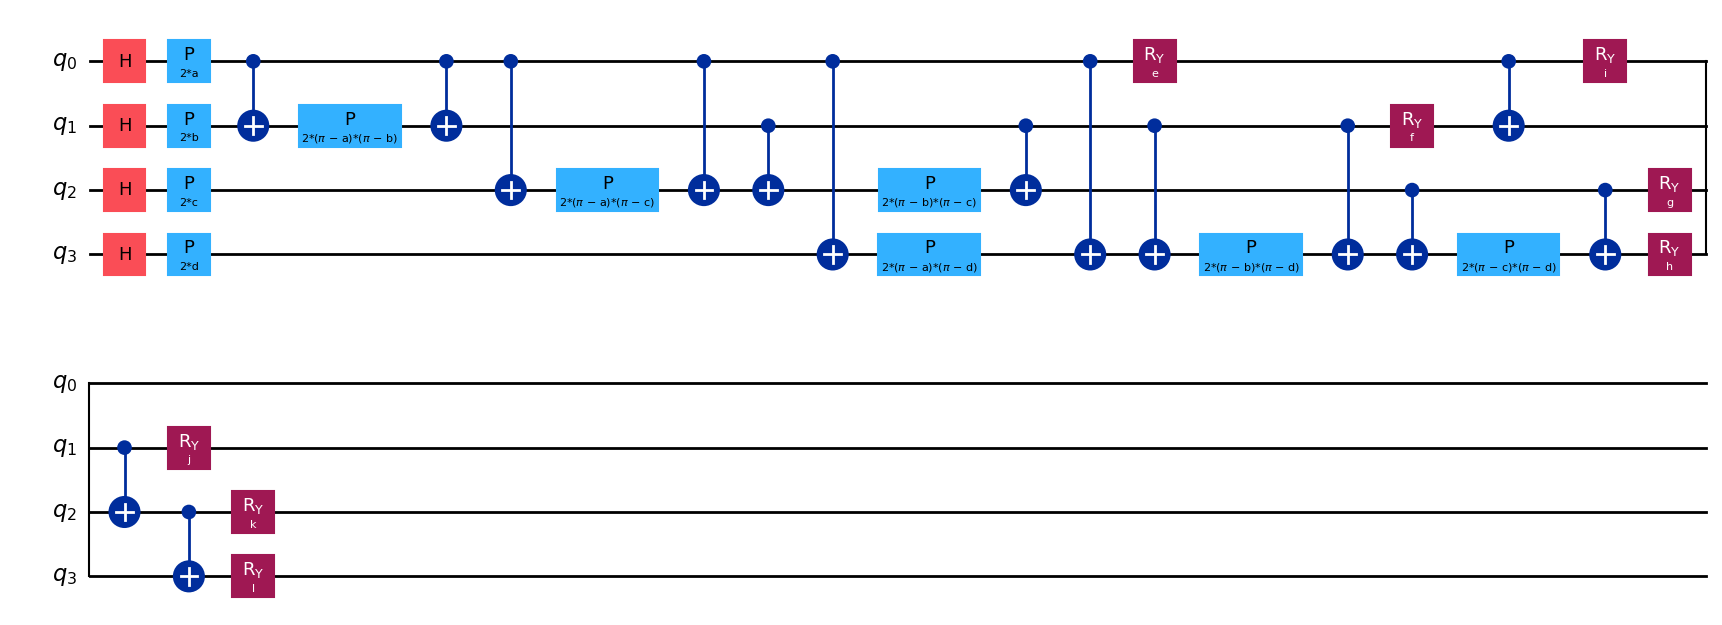

In [4]:
sv = Statevector.from_label('0' * n)
feature_map = create_zzfeaturemap(4)
var_form = create_realamplitudes(4)
circuit = feature_map.compose(var_form)
circuit.draw(output='mpl', filename="overallcircuit.png")

In [20]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.parameters):
        parameters[p] = params[i]
    return parameters

def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]
    
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
    class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

cost_list = []
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]
    probs = classify(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    cost_list.append(cost)
    return cost


In [21]:
cost_list = []

# define objective function for training
objective_function = lambda params: cost_function(X_train, Y_train, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
#opt_params = COBYLA(len(init_params), objective_function, initial_point=init_params)
opt_params = minimize(objective_function, init_params, method = "COBYLA")

# print results
print()
print('opt_params:', opt_params.x.tolist())
#print('opt_value: ', value)


KeyboardInterrupt: 

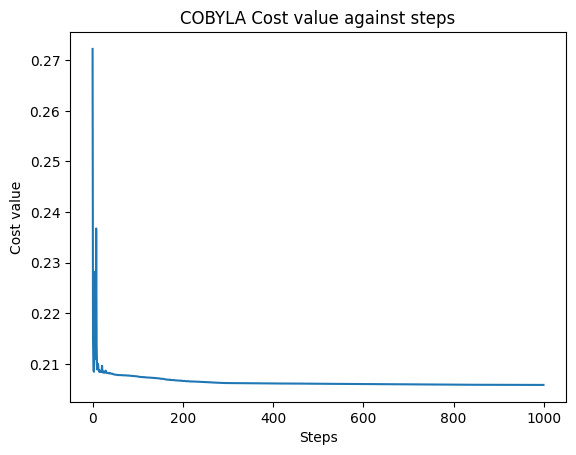

In [18]:
fig = plt.figure()
plt.plot(range(1000), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("COBYLA Cost value against steps")
plt.show()
#fig.savefig('../../Output/Figures/costvssteps.jpeg')


In [19]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        if (prob.get('yes') >= prob.get('no')) and (Y_test[i] == 0):
            accuracy += 1
        elif (prob.get('no') >= prob.get('yes')) and (Y_test[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

test_model(X_test, Y_test, class_labels, opt_params.x.tolist())


Test accuracy: 0.6363636363636364

